# Data Analytics I: Assignment 3

imports

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations
import csv

## Data Preprocessing

### 1. Forming transactional dataset

In [2]:
df = pd.read_csv("../ml-latest-small/ratings.csv")

df_filtered = df[df["rating"] > 2]

user_movie_counts = df_filtered.groupby("userId").size()
valid_users = user_movie_counts[user_movie_counts > 10].index

df_valid_users = df_filtered[df_filtered["userId"].isin(valid_users)]

transactional_data = (
    df_valid_users.groupby("userId")["movieId"].apply(set).reset_index()
)

In [3]:
transactional_data.to_csv("transactional_data.csv", index=False)

### 2. Train-test split

In [4]:
def split_movies(movies):
    movies = np.array(list(movies))
    np.random.shuffle(movies)
    split_idx = int(len(movies) * 0.8)
    train_movies = movies[:split_idx]
    test_movies = movies[split_idx:]
    return set(train_movies), set(test_movies)

In [5]:
train_data = []
test_data = []

for index, row in transactional_data.iterrows():
    user_id = row['userId']
    movies = row['movieId']
    
    train_movies, test_movies = split_movies(movies)
    
    train_data.append({'userId': user_id, 'movieId': train_movies})
    
    if test_movies:
        test_data.append({'userId': user_id, 'movieId': test_movies})

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [6]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## Association Rule Mining

### 1. Apriori Algorithm

In [7]:
def generate_candidates(Lk, k):
    """
    Generate candidate itemsets of size k+1 from frequent itemsets of size k.
    """
    candidates = set()
    Lk_list = list(Lk)
    
    for i in range(len(Lk_list)):
        for j in range(i + 1, len(Lk_list)):
            # Join step: create k+1 candidate itemset by combining two k-itemsets
            candidate = Lk_list[i].union(Lk_list[j])
            if len(candidate) == k + 1:
                candidates.add(candidate)
    
    return candidates


def prune_candidates(Ck, Lk, k):
    """
    Prune the candidate set Ck by removing itemsets where any (k-1)-subset is not in Lk.
    """
    
    pruned_candidates = set()
    for candidate in Ck:
        all_subsets_frequent = True
        for subset in combinations(candidate, k):
            if frozenset(subset) not in Lk:
                all_subsets_frequent = False
                break
        if all_subsets_frequent:
            pruned_candidates.add(candidate)

    return pruned_candidates


def get_frequent_itemsets(transactions, candidates, minsup):
    """
    Count the support of candidates and return the frequent itemsets.
    """

    candidate_counts = {candidate: 0 for candidate in candidates}
    
    # Count occurrences of each candidate in the transaction set
    for transaction in transactions:
        for candidate in candidates:
            if candidate.issubset(transaction):
                candidate_counts[candidate] += 1
    
    # Filter candidates by minimum support
    total_transactions = len(transactions)
    frequent_itemsets = {candidate for candidate, count in candidate_counts.items() if count / total_transactions >= minsup}
    
    return frequent_itemsets


In [8]:
def apriori(transactions, min_support):
    """
    Apriori algorithm to find frequent itemsets.
    transactions: list of transactions (each transaction is a set of items)
    min_support: minimum support threshold
    """
    # Step 1: Find frequent 1-itemsets
    item_support = {}
    for transaction in transactions:
        for item in transaction:
            if item not in item_support:
                item_support[item] = 0
            item_support[item] += 1

    total_transactions = len(transactions)
    L1 = {
        frozenset([item])
        for item, count in item_support.items()
        if count / total_transactions >= min_support
    }

    L = [L1]
    k = 1

    while L[k - 1]:
        # Step 2: Generate candidate itemsets of size k+1
        Ck = generate_candidates(L[k - 1], k)

        # Step 3: Prune candidate itemsets
        Ck = prune_candidates(Ck, L[k - 1], k)

        # Step 4: Get frequent itemsets from the candidate set
        Lk = get_frequent_itemsets(transactions, Ck, min_support)

        if Lk:
            L.append(Lk)
            k += 1
        else:
            break

    return set().union(*L) if L else set()

In [9]:
def calculate_support(itemset, transactions):
    """
    Calculate the support count of an itemset in the transactions.
    Returns the support as a fraction (support count / total_transactions).
    """
    total_transactions = len(transactions)
    count = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return count / total_transactions  

In [10]:

def generate_rules(frequent_itemsets, transactions, min_conf):
    """
    Generate association rules from frequent itemsets where the antecedent X is a single item,
    and the consequent Y can be a set.
    """
    rules = []
    
    for itemset in frequent_itemsets:
        itemset_list = list(itemset)
        if len(itemset_list) > 1:
            for item in itemset_list:
                antecedent = frozenset([item])  # Antecedent X is a single item
                consequent = itemset - antecedent  # Consequent Y is the rest of the itemset
                if consequent:
                    support_itemset = calculate_support(itemset, transactions)
                    support_antecedent = calculate_support(antecedent, transactions)
                    
                    confidence = support_itemset / support_antecedent
                    
                    if confidence >= min_conf:
                        rule = (antecedent, consequent, confidence, support_itemset)
                        rules.append(rule)
    
    return rules


In [11]:
transactions = [set(movies) for movies in train_df['movieId']]

In [12]:
min_support = 0.05

frequent_itemsets = apriori(transactions, min_support)

print(f"Frequent Itemsets: {frequent_itemsets}")

Frequent Itemsets: {frozenset({1036, 1198}), frozenset({1193, 2571}), frozenset({4306, 780}), frozenset({588, 5349}), frozenset({377, 589, 110}), frozenset({8360, 1210}), frozenset({3948, 780}), frozenset({480, 2028, 110}), frozenset({2858, 1732, 260}), frozenset({7361, 47}), frozenset({296, 2683}), frozenset({32, 357}), frozenset({2762, 4262}), frozenset({296, 595, 318}), frozenset({2858, 2571, 260}), frozenset({1968, 1682, 50}), frozenset({7153, 4306}), frozenset({592, 1580, 110}), frozenset({32, 1682, 1196}), frozenset({296, 1, 589}), frozenset({1136, 500}), frozenset({7153, 260, 2959}), frozenset({296, 904}), frozenset({5952, 4993, 2858}), frozenset({380, 1196, 1270}), frozenset({593, 260, 1210, 1196}), frozenset({50, 364}), frozenset({4993, 7153, 2959}), frozenset({4993, 1653}), frozenset({344, 110}), frozenset({858, 5349}), frozenset({480, 457, 780, 589}), frozenset({1196, 1270, 2959}), frozenset({356, 349, 165}), frozenset({4993, 46578}), frozenset({2683, 1196, 588}), frozenset(

In [13]:
min_conf = 0.7

rules = generate_rules(frequent_itemsets, transactions, min_conf)

for rule in rules:
    antecedent, consequent, confidence, support = rule
    print(f"Rule: {set(antecedent)} -> {set(consequent)}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {1732} -> {296}, Confidence: 0.70, Support: 0.10
Rule: {59784} -> {68954}, Confidence: 0.73, Support: 0.06
Rule: {7143} -> {356}, Confidence: 0.72, Support: 0.06
Rule: {2000} -> {1196}, Confidence: 0.73, Support: 0.07
Rule: {59784} -> {356}, Confidence: 0.71, Support: 0.06
Rule: {7143} -> {4993}, Confidence: 0.72, Support: 0.06
Rule: {6934} -> {5952}, Confidence: 0.73, Support: 0.06
Rule: {48774} -> {2959}, Confidence: 0.74, Support: 0.06
Rule: {46578} -> {2959}, Confidence: 0.71, Support: 0.08
Rule: {33493} -> {1196}, Confidence: 0.85, Support: 0.07
Rule: {56174} -> {318}, Confidence: 0.74, Support: 0.05
Rule: {51255} -> {2959}, Confidence: 0.80, Support: 0.06
Rule: {8641} -> {2959}, Confidence: 0.80, Support: 0.06
Rule: {2529} -> {1196}, Confidence: 0.74, Support: 0.05
Rule: {1573} -> {1210}, Confidence: 0.73, Support: 0.07
Rule: {596} -> {1}, Confidence: 0.73, Support: 0.05
Rule: {1374} -> {1196}, Confidence: 0.73, Support: 0.06
Rule: {91529} -> {79132}, Confidence: 0.71, Supp

### 2. Recommendation

In [14]:
def top_rules_by_metric(rules, metric, top_n=100):
    """
    Get the top N rules sorted by a specified metric.
    metric_index: index of the metric to sort by (2 for confidence, 3 for support)
    top_n: number of top rules to return
    """
    if metric == 'support':
        metric_index = 3
    elif metric == 'confidence':
        metric_index = 2

    sorted_rules = sorted(rules, key=lambda x: x[metric_index], reverse=True)
    return sorted_rules[:top_n]

In [15]:
def load_movie_titles(movies_file):
    movie_titles = {}
    with open(movies_file, mode="r", encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            movie_id = int(row["movieId"])
            title = row["title"]
            movie_titles[movie_id] = title
    return movie_titles


def movie_ids_to_titles(itemset, movie_titles):
    return {movie_titles[movie_id] for movie_id in itemset}

movie_titles = load_movie_titles('../ml-latest-small/movies.csv')

top 100 association rules based on support and confidence

In [16]:
top_100_support = top_rules_by_metric(rules, 'support') 
top_100_confidence = top_rules_by_metric(rules, 'confidence')

team_id = 51


with open(f'{team_id}_top100RulesBySup.txt', 'w') as f:
    for rule in top_100_support:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")

with open(f'{team_id}_top100RulesByConf.txt', 'w') as f:
    for rule in top_100_confidence:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")


rules that appear in both lists, arranged based on their confidence score

In [17]:
rules_support_set = set((rule[0], rule[1]) for rule in top_100_support)
rules_confidence_set = set((rule[0], rule[1]) for rule in top_100_confidence)

shared_rules = rules_support_set.intersection(rules_confidence_set)
filtered_shared_rules = [rule for rule in top_100_confidence if (rule[0], rule[1]) in shared_rules]
sorted_shared_rules = sorted(filtered_shared_rules, key=lambda x: x[2], reverse=True)


for rule in sorted_shared_rules:
    antecedent, consequent, confidence, support = rule
    antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
    consequent_titles = movie_ids_to_titles(consequent, movie_titles)
    print(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {'Spaceballs (1987)'} -> {'Star Wars: Episode V - The Empire Strikes Back (1980)'}, Confidence: 0.90, Support: 0.06
Rule: {'American Psycho (2000)'} -> {'Fight Club (1999)'}, Confidence: 0.88, Support: 0.06
Rule: {'Star Wars: Episode III - Revenge of the Sith (2005)'} -> {'Star Wars: Episode V - The Empire Strikes Back (1980)'}, Confidence: 0.85, Support: 0.07
Rule: {'Spaceballs (1987)'} -> {'Star Wars: Episode VI - Return of the Jedi (1983)'}, Confidence: 0.83, Support: 0.06
Rule: {'Goonies, The (1985)'} -> {'Star Wars: Episode V - The Empire Strikes Back (1980)'}, Confidence: 0.81, Support: 0.06
Rule: {'Little Mermaid, The (1989)'} -> {'Aladdin (1992)'}, Confidence: 0.81, Support: 0.06
Rule: {'Abyss, The (1989)'} -> {'Star Wars: Episode VI - Return of the Jedi (1983)'}, Confidence: 0.81, Support: 0.06
Rule: {'Hot Fuzz (2007)'} -> {'Fight Club (1999)'}, Confidence: 0.80, Support: 0.06
Rule: {'Cliffhanger (1993)'} -> {'True Lies (1994)'}, Confidence: 0.80, Support: 0.09
Rule: {'R

In [18]:

# Generate global frequent itemsets
global_frequent_itemsets = frequent_itemsets

# Generate global association rules from these itemsets
global_rules = rules

# Now use these global rules for each user
avg_recalls = []
avg_precisions = []
# Loop over the number of rules to consider, from 1 to 10
for i in range(1, 11):
    total_recall = 0
    total_precision = 0
    
    # Loop over each user in the train set
    for j in range(len(train_df)):
        recom_set = set()
        user_test = set(test_df.iloc[j]['movieId'])  # Test data for user j
        
        # Select top 'i' rules for the user from the global rules
        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        # Calculate recall
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        total_recall += recall
        
        # Calculate precision
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        total_precision += precision
    
    # Compute average recall and precision for this value of 'i'
    avg_recalls.append(total_recall / len(train_df))  # Divide by number of users
    avg_precisions.append(total_precision / len(train_df))  # Divide by number of users


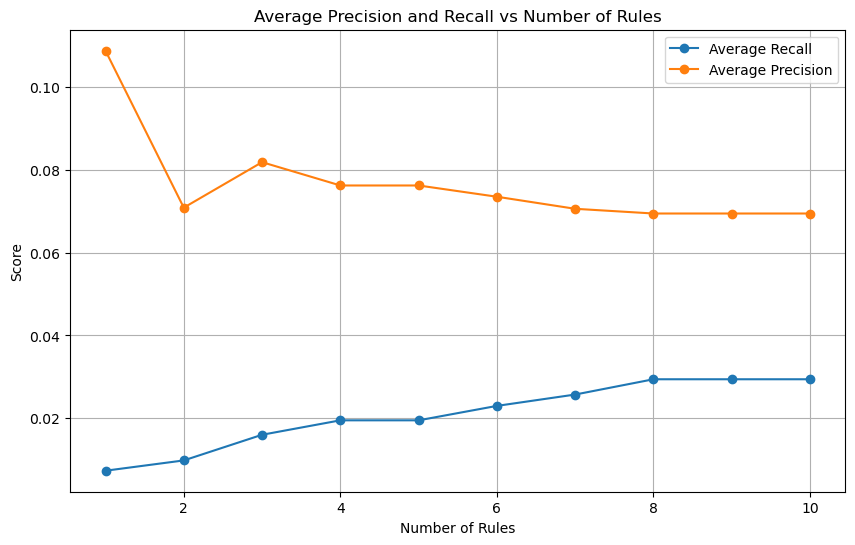

In [19]:
# Plot the average precision and recall
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), avg_recalls, label='Average Recall', marker='o')
plt.plot(range(1, 11), avg_precisions, label='Average Precision', marker='o')
plt.xlabel('Number of Rules')
plt.ylabel('Score')
plt.title('Average Precision and Recall vs Number of Rules')
plt.legend()
plt.grid(True)
plt.show()

In [20]:

# Generate global frequent itemsets
global_frequent_itemsets = frequent_itemsets

# Generate global association rules from these itemsets
global_rules = rules

# Now use these global rules for each user
avg_recalls = []
avg_precisions = []

# Loop over the number of rules to consider, from 1 to 10
for i in range(1, 11):
    total_recall = 0
    total_precision = 0
    
    # Loop over each user in the train set
    for j in range(len(train_df)):
        recom_set = set()
        user_test = set(test_df.iloc[j]['movieId'])  # Test data for user j
        
        # Select top 'i' rules for the user from the global rules
        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        # Calculate recall
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        total_recall += recall
        
        # Calculate precision
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        total_precision += precision
    
    # Compute average recall and precision for this value of 'i'
    avg_recalls.append(total_recall)
    avg_precisions.append(total_precision)




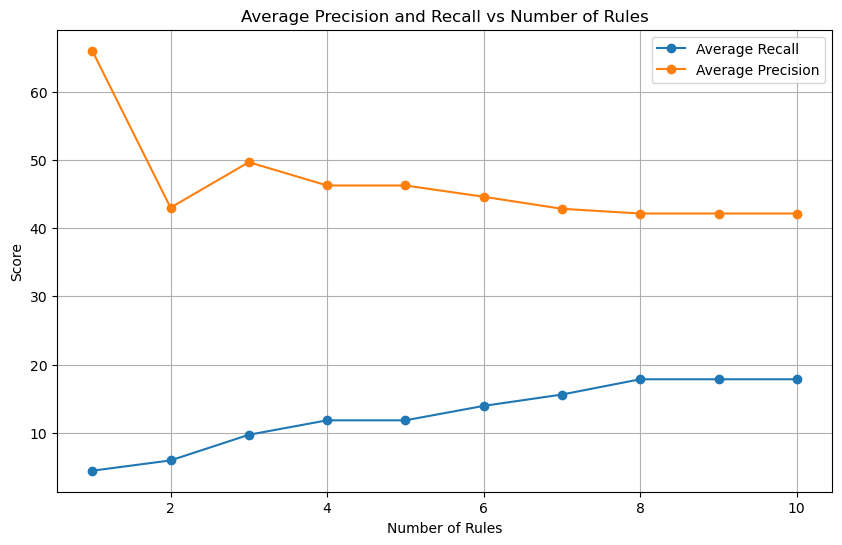

In [21]:
# Plot the average precision and recall
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), avg_recalls, label='Average Recall', marker='o')
plt.plot(range(1, 11), avg_precisions, label='Average Precision', marker='o')
plt.xlabel('Number of Rules')
plt.ylabel('Score')
plt.title('Average Precision and Recall vs Number of Rules')
plt.legend()
plt.grid(True)
plt.show()

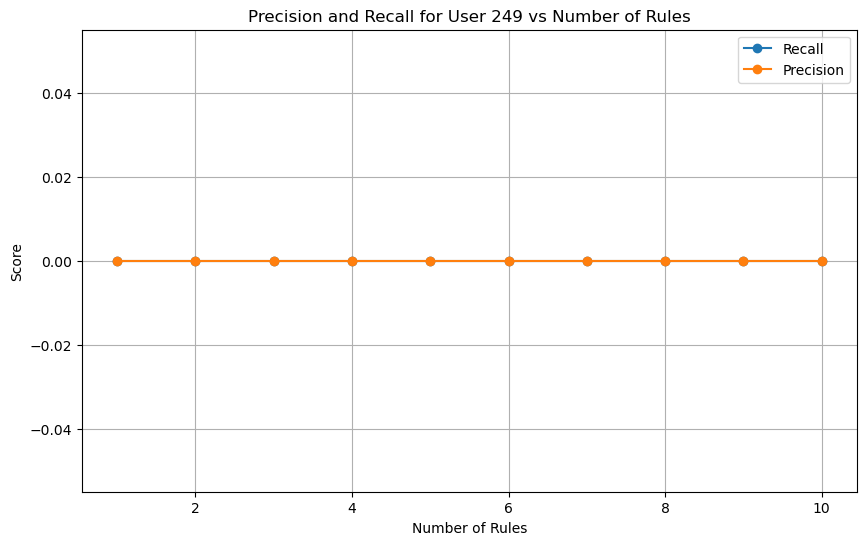

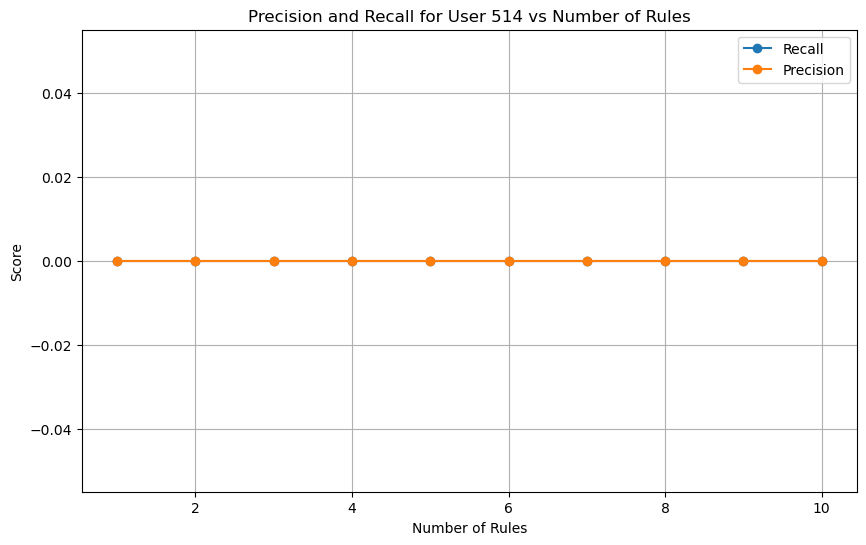

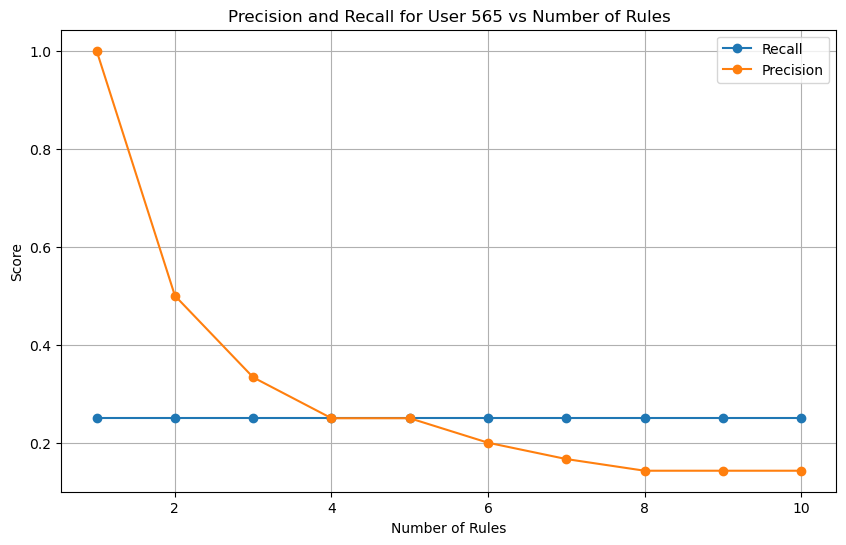

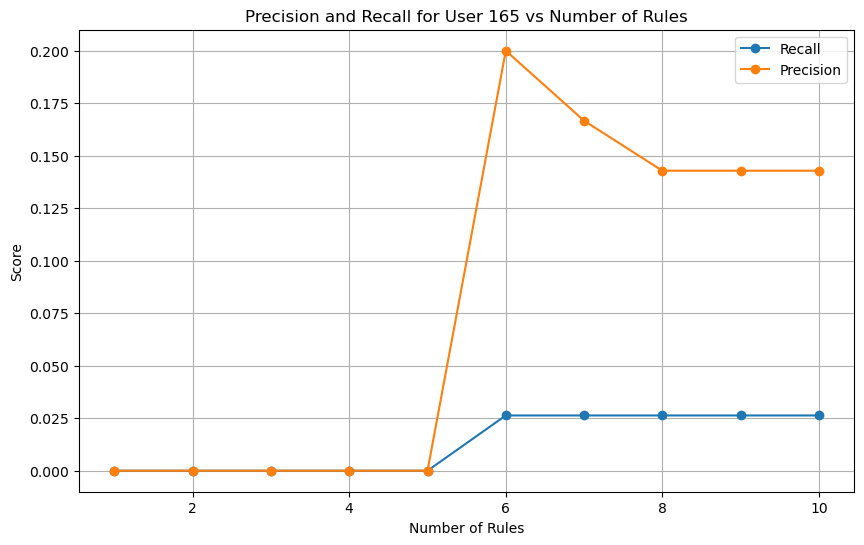

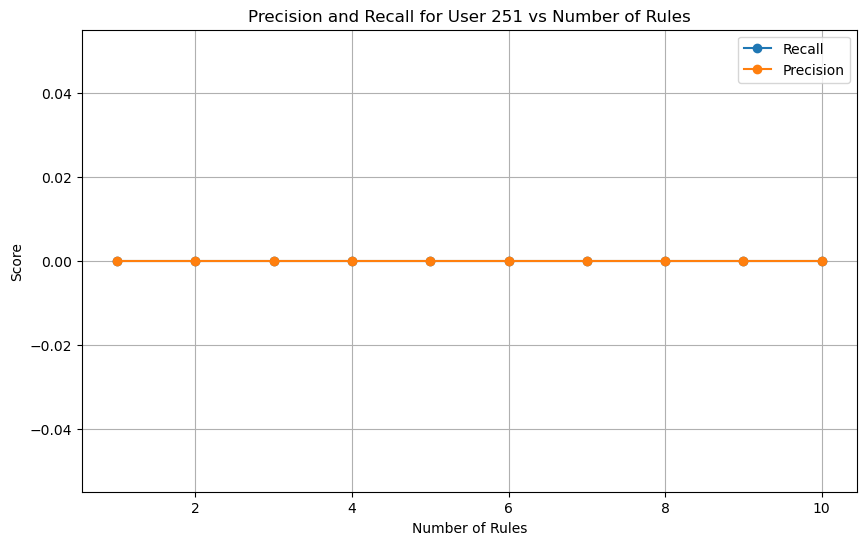

In [22]:
# choose 5 random users from the test set
import random

random.seed(51)
random_users = random.sample(range(len(test_df)), 5)

# for each of these users display their precision and recall graphs

for user in random_users:
    user_data = set(train_df.iloc[user]['movieId'])  # Training data for user
    user_test = set(test_df.iloc[user]['movieId'])   # Test data for user
    
    avg_recalls = []
    avg_precisions = []
    
    # Loop over the number of rules to consider, from 1 to 10
    for i in range(1, 11):
        recom_set = set()
        # Generate rules from user_data
        user_transactions = [user_data]  # Treat this as a transaction

        # Select top 'i' rules for the user
        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        # Calculate recall
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        avg_recalls.append(recall)
        
        # Calculate precision
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        avg_precisions.append(precision)
    
    # Plot the precision and recall for this user
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), avg_recalls, label='Recall', marker='o')
    plt.plot(range(1, 11), avg_precisions, label='Precision', marker='o')
    plt.xlabel('Number of Rules')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall for User {user} vs Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()

    


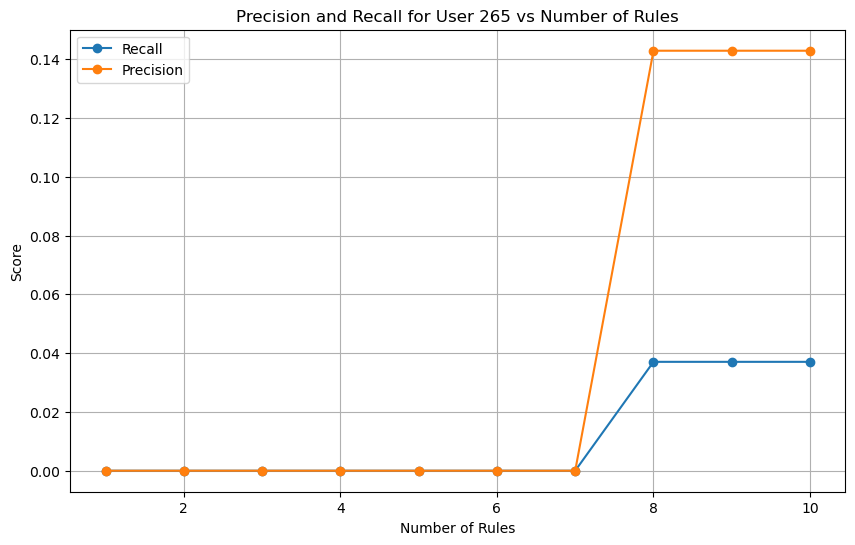

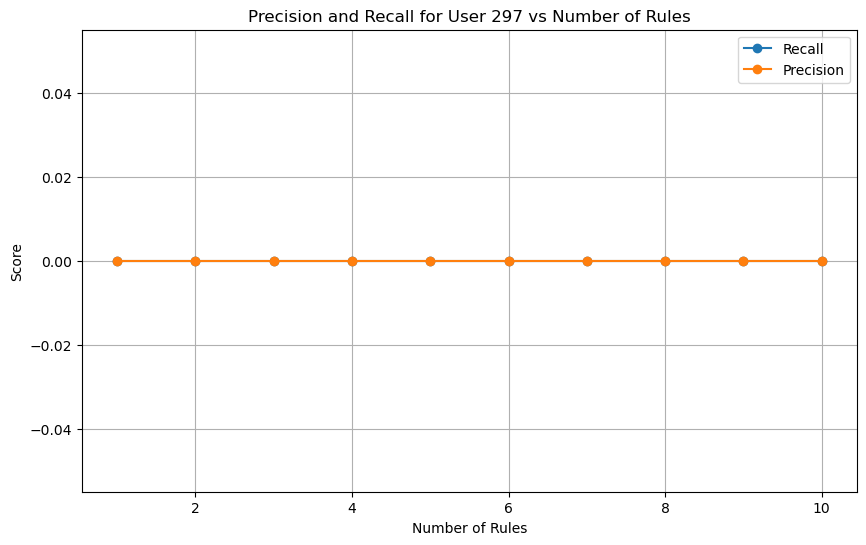

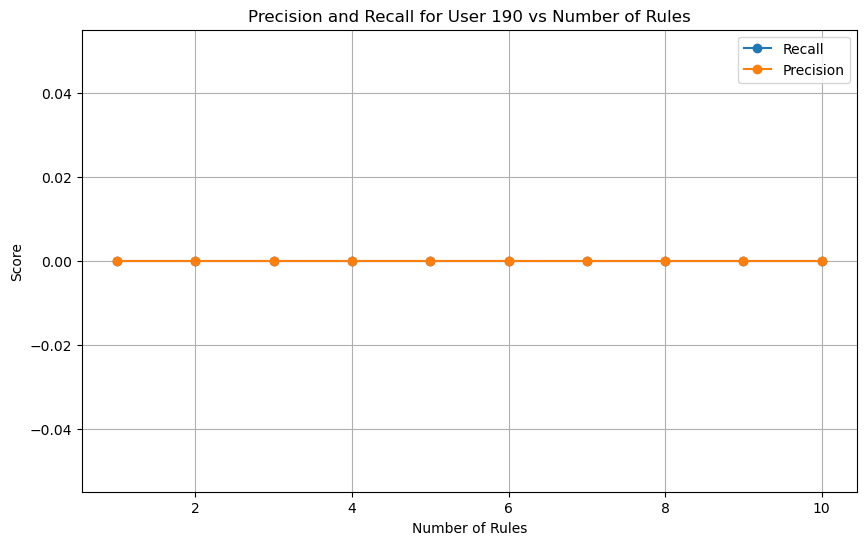

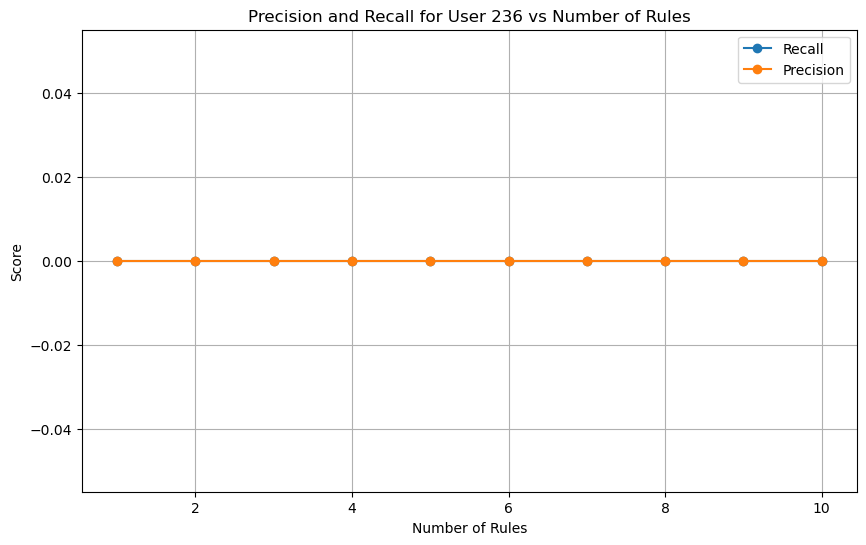

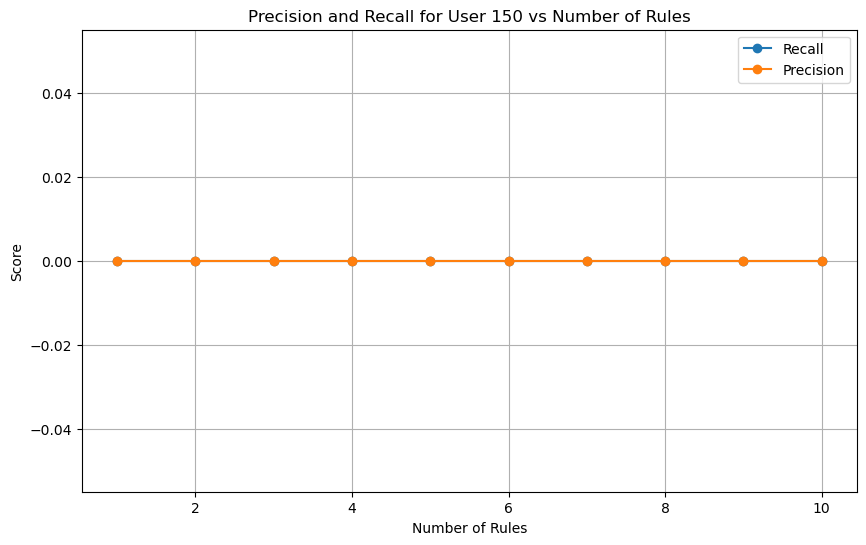

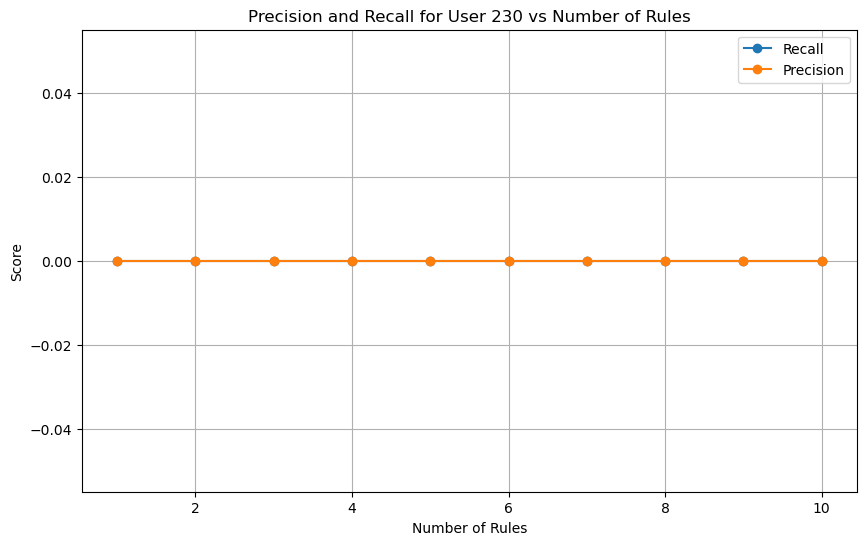

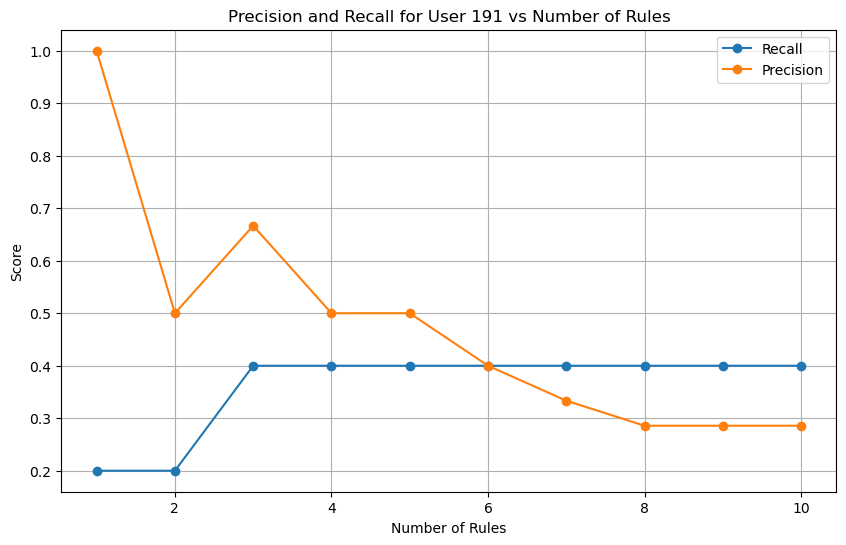

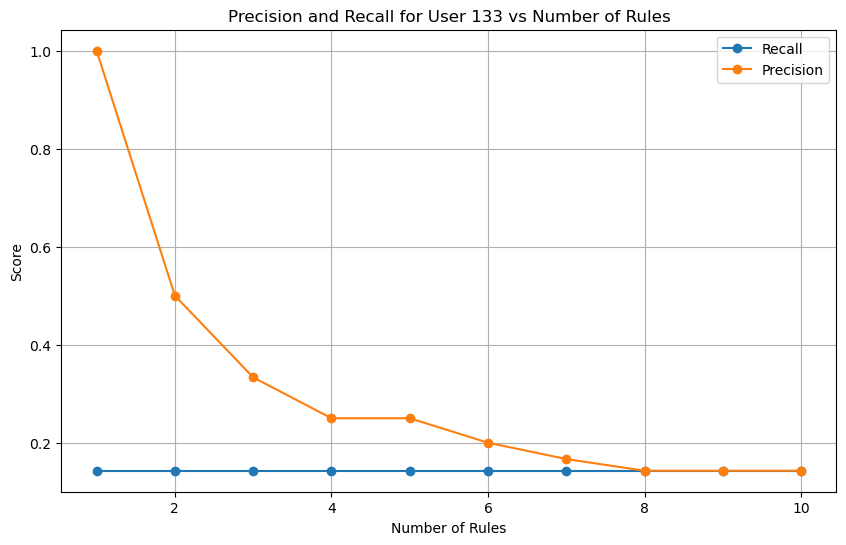

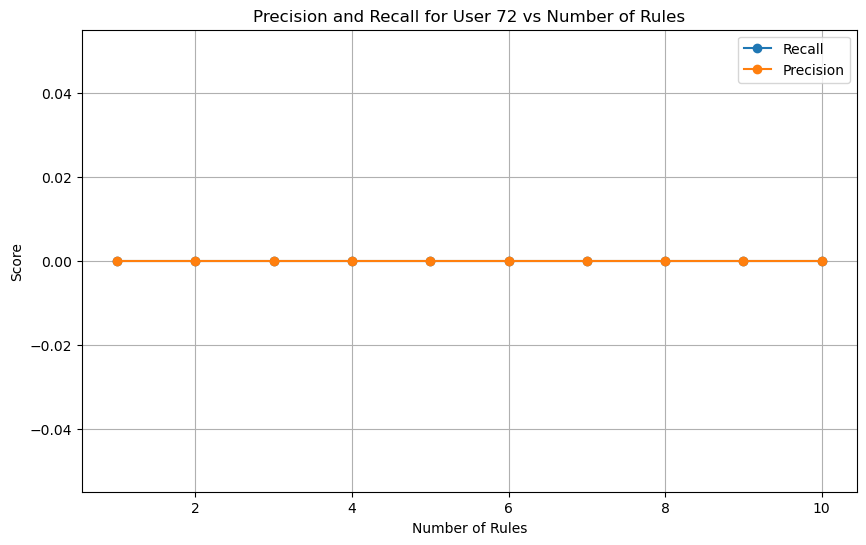

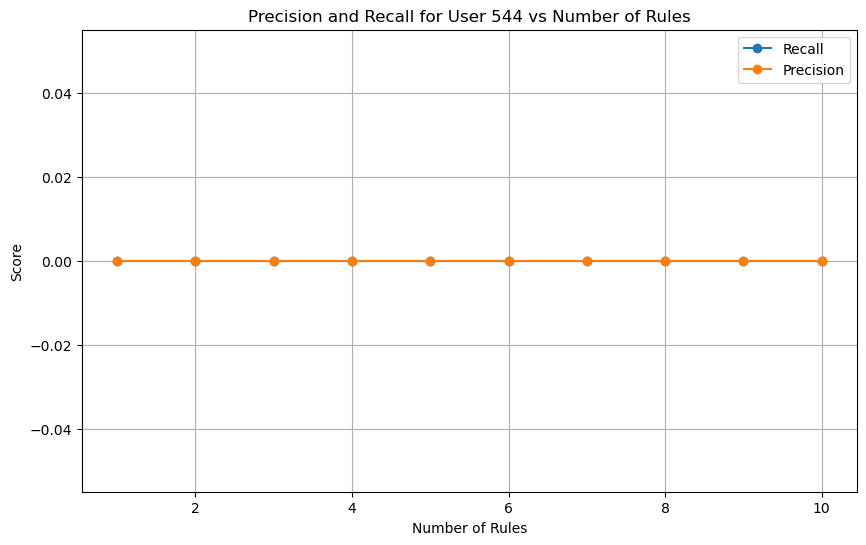

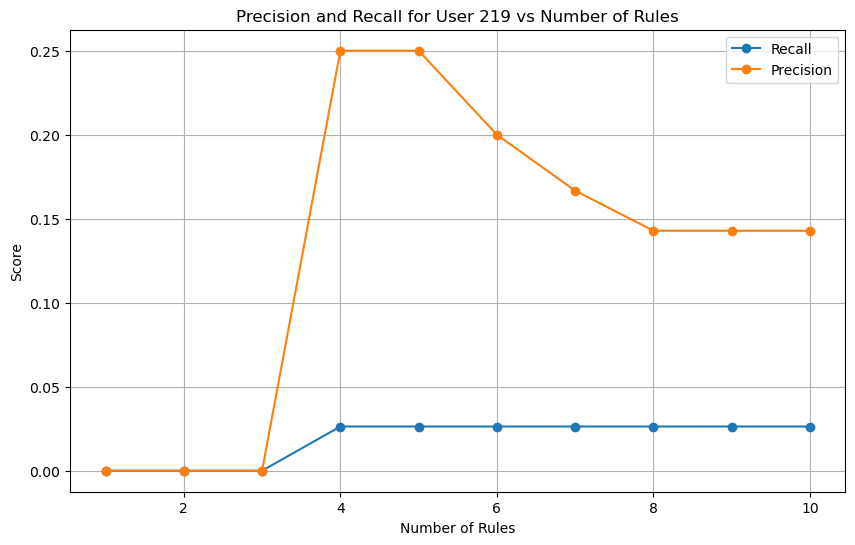

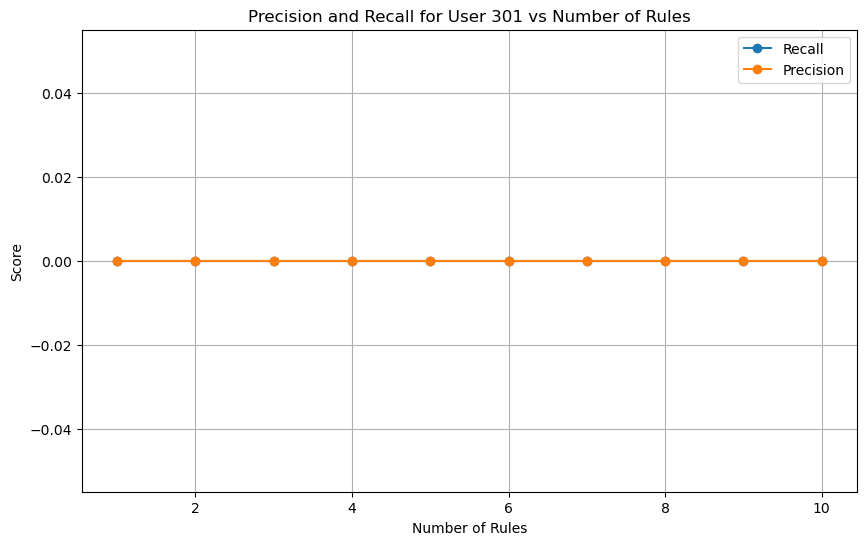

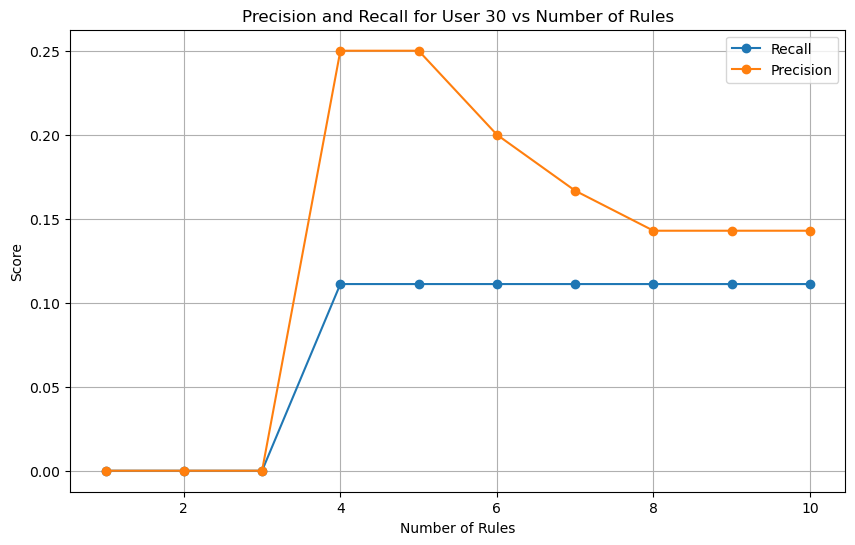

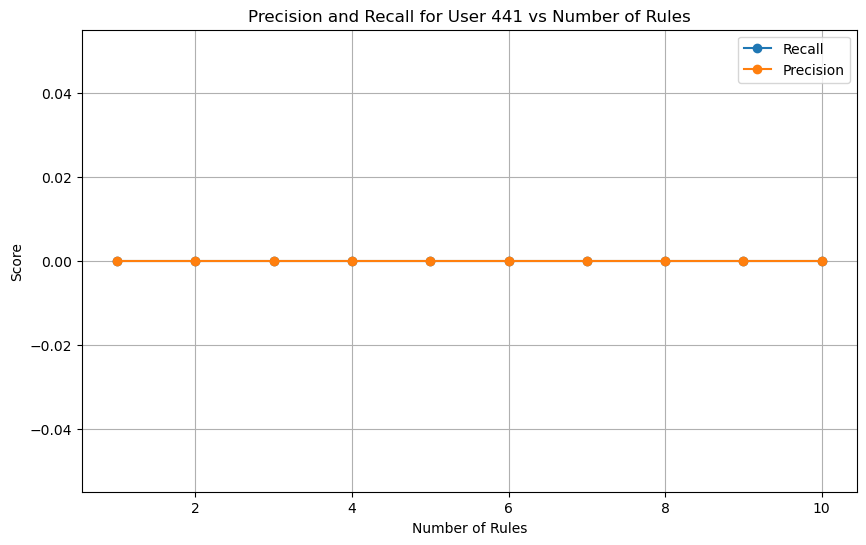

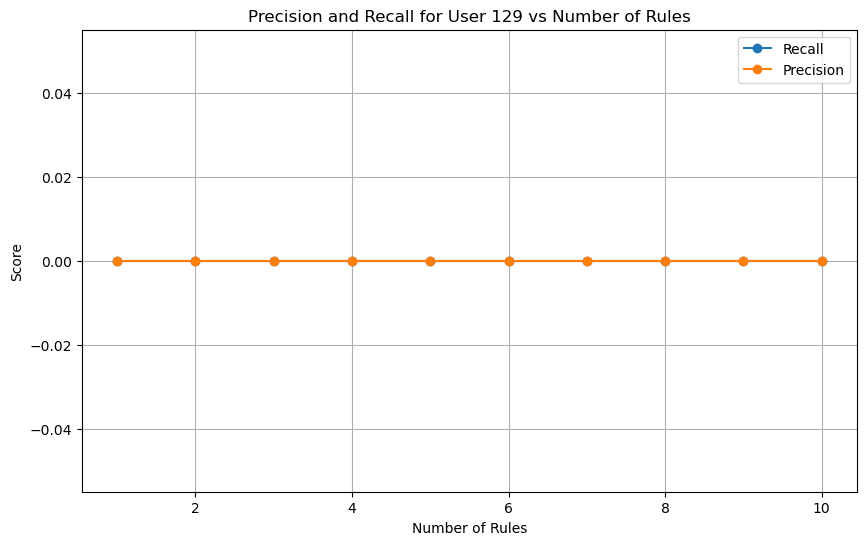

In [23]:
# choose 5 random users from the test set
import random

random.seed(13)
random_users = random.sample(range(len(test_df)), 15)

# for each of these users display their precision and recall graphs

for user in random_users:
    user_data = set(train_df.iloc[user]['movieId'])  # Training data for user
    user_test = set(test_df.iloc[user]['movieId'])   # Test data for user
    
    avg_recalls = []
    avg_precisions = []
    
    # Loop over the number of rules to consider, from 1 to 10
    for i in range(1, 11):
        recom_set = set()
        # Generate rules from user_data
        user_transactions = [user_data]  # Treat this as a transaction

        # Select top 'i' rules for the user
        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        # Calculate recall
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        avg_recalls.append(recall)
        
        # Calculate precision
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        avg_precisions.append(precision)
    
    # Plot the precision and recall for this user
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), avg_recalls, label='Recall', marker='o')
    plt.plot(range(1, 11), avg_precisions, label='Precision', marker='o')
    plt.xlabel('Number of Rules')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall for User {user} vs Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()

    
